In [1]:
import pandas as pd
from __future__ import division
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import time

from IPython.display import display, clear_output

In [2]:
class prepare_data:
    def __init__(self, path_json_file, ratio=[0.8, 0.1, 0.1]):
        self.data = pd.read_json(path_or_buf=path_json_file)[["band_1", "band_2", "inc_angle", "is_iceberg"]]
        self.ratio = ratio
        self.whole_dataset = np.array([])  
        print("All data size:", self.data.shape)
        
        
    def exclude_missing_inc_angle(self):
        """
        Column `inc_angle` has value `na` in some rows (around 12% of data) and those rows are excluded
        """
        self.data = self.data[self.data.inc_angle != "na"]
    
    
    def normalize_inc_angle(self):
        """
        Normalize column `inc_angle` in [−1,1]
        """
        self.data["inc_angle"] = (2*((self.data["inc_angle"] - min(self.data["inc_angle"]))/ (max(self.data["inc_angle"] - min(self.data["inc_angle"]))))-1)
        
        
    def shuffle_data(self):
        """
        Random shuffle data
        """
        self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    
    def array_to_matrix(self, a):
        """
        Convert array with actual values - `y` - to a binary matrix
        """
        mtrx = np.zeros((len(a),2))
        for x in range(0,2):
            indices = np.where(np.array(a).reshape(-1,1)[:,0]==x)
            mtrx[indices, x] = 1
        return(mtrx)
    
    
    def reduce_spatial_dimension(self, image):
        """
        Reduces dimension of a 75x75 image to 25x25
        According to numpy.nbytes, the size of image before reduction is 45kB and 5kB after
        Inputs:
        - image: 2d array
        Returns:
        - reduced_image: Reduced image
        """
        image = image.reshape(75, 75)
        #print(image.shape)
        reduced_image = np.zeros((25, 25))
        filter_size = reduced_image.shape[0]
        padding = int(image.shape[0] / reduced_image.shape[0])
        counter = 0
        counter_i = 0 # counter in i loop for indexing rows
        for i in range(0, image.shape[0], padding):
            counter_j = 0 # counter in j loop for indexing columns
            for j in range(0, image.shape[1], padding):
                max_val = np.max(image[i:padding+i, j:padding+j])
                counter += 1
                reduced_image[counter_i][counter_j] = max_val
                counter_j += 1
            counter_i += 1
        return reduced_image.flatten()
    
    
    def prepare_columns(self):
        """
        Function converts Pandas columns to Numpy array, normalizes columns band_1 and band_2
        and creates a new column with average values of band_1 and band_2
        """
        self.shuffle_data()
        
        x_band_1 = np.array(self.data["band_1"].tolist())
        x_band_2 = np.array(self.data["band_2"].tolist())
        x_inc_angle = np.array(self.data["inc_angle"].tolist()).reshape(-1,1)
        y_is_iceberg = self.array_to_matrix(np.array(self.data["is_iceberg"].tolist()).reshape(-1,1))
        
        # Normalize arrays `band_1` and `band_2` in  [−1,1], create array with average band values
        x_band_1_norm = 2*((x_band_1 - np.min(x_band_1)) / (np.max(x_band_1) - np.min(x_band_1)))-1
        x_band_2_norm = 2*((x_band_2 - np.min(x_band_2)) / (np.max(x_band_2) - np.min(x_band_2)))-1
        temp_band_avg = np.add(x_band_1_norm, x_band_2_norm)/2
        x_band_avg = np.apply_along_axis(self.reduce_spatial_dimension, 1, temp_band_avg)
        print("x_band_avg.shape:", x_band_avg.shape)
        # Create the `whole_dataset_avg` matrix by stacking `x_inc_angle`, `x_band_avg` and `y_is_iceberg` arrays
        # and do sanity check (print the shape of matrix)
        self.whole_dataset = np.hstack((x_inc_angle, x_band_avg, y_is_iceberg))
        print("Size of the whole dataset for training::", self.whole_dataset.shape)
                
            
    def prepare_sets(self):
        """
        Prepare train, validate and test sets
        """
        max_num_train = int(len(self.whole_dataset)*self.ratio[0])
        max_num_validate = int(len(self.whole_dataset)*self.ratio[1])
        max_num_test = int(len(self.whole_dataset)*self.ratio[2])
        print("Split:", max_num_train, max_num_validate, max_num_test)

        X_train = self.whole_dataset[:max_num_train, :-2]
        y_train = self.whole_dataset[:max_num_train, -2:]
        X_validate = self.whole_dataset[max_num_train : max_num_train+max_num_validate, :-2]
        y_validate = self.whole_dataset[max_num_train : max_num_train+max_num_validate, -2:]
        X_test = self.whole_dataset[max_num_train+max_num_validate:, :-2]
        y_test = self.whole_dataset[max_num_train+max_num_validate:, -2:]
        
        print("X_train:", X_train.shape)
        print("y_train:", y_train.shape)
        print("X_validate:", X_validate.shape)
        print("y_validate:", y_validate.shape)
        print("X_test:", X_test.shape)
        print("y_test:", y_test.shape)

        return X_train, y_train, X_validate, y_validate, X_test, y_test

In [3]:
class mlp:
    def __init__(self, n_neurons_input, n_neurons_hidden, n_targets, learning_rate=0.5, beta=1):
        np.set_printoptions(suppress=True) #suppress scientific notation
        self.n_neurons_input = n_neurons_input
        self.n_targets = n_targets # number of target neurons
        self.n_neurons_hidden = n_neurons_hidden # number of neurons in hidden layer

        #intervals for picking random weights for hidden layer
        low_hidden = -1/math.sqrt(self.n_neurons_input)
        high_hidden = 1/math.sqrt(self.n_neurons_input)
        self.weights_hidden = np.random.uniform(low_hidden, high_hidden, size=(self.n_neurons_input, self.n_neurons_hidden))

        #intervals for picking random weights for output layer
        low_output = -1/math.sqrt(self.n_neurons_hidden)
        high_output = 1/math.sqrt(self.n_neurons_hidden)
        self.weights_output =  np.random.uniform(low_output, high_output, size=(self.n_targets, self.n_neurons_hidden))

        self.bias_hidden_weight = np.array([np.random.rand()] * self.n_neurons_hidden)
        self.bias_output_weight = np.array([np.random.rand()] * self.n_targets)
        self.learning_rate = learning_rate
        self.beta = beta #hyperparameter used in sigmoid function

        #prepare the arrays
        self.hidden_layer_activation = np.array([0.] * self.n_neurons_hidden)
        self.hidden_layer_activation_f_output = np.array([0.] * self.n_neurons_hidden)
        self.hidden_layer_error = np.array([0.] * self.n_neurons_hidden)
        self.output_layer_output = np.array([0.] * self.n_targets)
        self.output_layer_activation = np.array([0.] * self.n_targets)
        self.output_layer_error = np.array([0.] * self.n_targets)

        self.all_total_errors = np.array([])
        
        self.validation_error = []
        
    def sigmoid(self, x, beta):
        """
        Activation function (sigmoid function, continuous-log sigmond function)
        Sigmoid is acceptable when having a classification problem
        Inputs:
        - x: float
        - beta: slope parameter
        Returns float
        """
        return 1 / (1 + math.exp(-x * beta))
    
    def derivative_sigmoid(self, a):
        """
        Calculates the derivative of sigmoid function - x*(1-x)
        Inputs:
        - a: array of floats
        Returns derivative of the array
        """
        return (a*(1-a))

    def forward_hidden_layer(self, inputs):
        """
        Calculates hidden layer activations and outputs from activation function
        Inputs: 
        - inputs: array (row) of training data
        Returns:
        - hla: hidden layer activation
        - hlafo: hidden layer with applied activation function
        """
        hla = np.transpose(np.dot(np.transpose(inputs), self.weights_hidden))
        hlafo = np.array([self.sigmoid(x, self.beta) for x in np.transpose(hla)])
        return hla, hlafo

    def forward_output_layer(self, sigmoid_from_hidden_layer):
        """
        Calculate output layer based on values from the hidden layer
        Inputs:
        - sigmoid_from_hidden_layer: array with values after activation function has been applied
                                     length = number of neurons in the hidden layer
        Returns:
        - olo: array for output from output layer
        - ola: array for output from output layer activation
        """
        n_rows = sigmoid_from_hidden_layer.shape[0]
        olo = np.dot(sigmoid_from_hidden_layer.reshape(1,n_rows), np.transpose(self.weights_output)) + self.bias_output_weight
        ola = np.array([self.sigmoid(x, self.beta) for x in np.transpose(olo)])
        return olo, ola

    def calculate_total_error(self, t, o):
        """
        Calculate error between actual targets (t) and output targets (o)
        Inputs:
        - t: actual target (y) values. Array either [1, 0] or [0, 1] 
        - o: calculated values. Array of floats with length 2
        Returns:
        - total_error: float 
        """
        total_error = np.sum(1/2 * (t - o) ** 2)
        return total_error

   ################################# 
   # Functions for backpropagation #
   #################################
    
    ##for every output neuron
    def calculate_output_error(self):
        """
        Calculates output error before going into backpropagation
        """
        self.output_layer_error = (self.output_layer_activation - self.targets) * self.output_layer_activation * (1 - self.output_layer_activation)

    
    def backward_hidden_error(self):
        """
        Calculate the error in the hidden layer
        """
        #first part of the equation - the derivative of the activation function - (x*(1-x))
        derivative_part = self.derivative_sigmoid(self.hidden_layer_activation_f_output) #self.hidden_layer_activation_f_output * (1 - self.hidden_layer_activation_f_output)
        # second part of the equation - sum of product of weights in hidden layer and the error of the output
        n_rows_ole = self.output_layer_error.shape[0]
        n_rows_hla = self.hidden_layer_activation.shape[0]
        #a matrix is returned and the diagonal has the values we are after
        self.hidden_layer_error2 =  np.diagonal(np.transpose(derivative_part) * self.hidden_layer_activation.reshape(n_rows_hla,1) * np.transpose(self.output_layer_error.reshape(n_rows_ole,1)[0]))

    def update_output_layer_weights(self):
        """
        Updates weights in the output layer
        """
        n_rows = self.hidden_layer_activation_f_output.shape[0]
        self.weights_output = self.weights_output - np.transpose(self.learning_rate * self.output_layer_error * np.transpose(self.hidden_layer_activation_f_output.reshape(1,n_rows)))
        self.bias_output_weight = self.bias_output_weight - (self.learning_rate * self.output_layer_error * 1)

    def update_hidden_layer_weights(self):
        """
        Updates weights in the hidden layer
        """
        n_rows = self.inputs.shape[0]
        self.weights_hidden = self.weights_hidden - (self.learning_rate * self.hidden_layer_error * np.transpose(self.inputs.reshape(1, n_rows)))
        self.bias_hidden_weight = self.bias_hidden_weight - (self.learning_rate * self.hidden_layer_activation * 1)

    ##################
    ##train network  #
    ################
    def train(self, inputs, targets):
        """
        Calls all methods for forward and back pass through the network
        Inputs:
        - inputs: array of floats - one test sample
        - targets: array of targets - correct output value
        """
        self.inputs = inputs
        self.n_inputs = self.inputs.shape[0]
        self.targets = targets

        ## Forward pass #
        self.hidden_layer_activation, self.hidden_layer_activation_f_output = self.forward_hidden_layer(self.inputs)
        self.output_layer_output, self.output_layer_activation = self.forward_output_layer(self.hidden_layer_activation_f_output)
        self.calculate_total_error(self.targets, self.output_layer_activation)

        ## Backward pass #
        self.calculate_output_error()
        self.backward_hidden_error()
        self.update_output_layer_weights()
        self.update_hidden_layer_weights()
    #end train

    def train_network(self, train, target, n_epoch=10):
        self.n_epoch = n_epoch
        n_rows = train.shape[0]
        for epoch in range(self.n_epoch):
            for i in range(0, n_rows):
                self.train(train[i], target[i])
            print("epoch number:", epoch, ", error=",  self.calculate_total_error(self.targets, self.output_layer_activation))

    def early_stopping(self, train, target, valid, valid_target, n_epoch=10):
        self.n_epoch = n_epoch
        n_rows = train.shape[0]
        previous_valid_error = 100
        message = ""
        for epoch in range(self.n_epoch):
            for i in range(0, n_rows):
                #print("row", i)
                self.train(train[i], target[i])
            #print("early stopping: self.output_layer_activation", self.output_layer_activation.shape, target.shape)
            #print("number of training rows processed:", n_rows)
            #print("VALIDATE!")
            test_error = self.calculate_total_error(self.targets, self.output_layer_activation)
            valid_error = self.forward_pass_with_calculated_error(valid, valid_target)
            self.validation_error.append(valid_error) # list for visualizing validation error
            
            #early break is in effect after 10% of the epochs is run
            if (epoch > self.n_epoch/10) and (valid_error > previous_valid_error):
            #if (valid_error > previous_valid_error):
                message = "STOP"
            previous_valid_error = valid_error
            #print("epoch number:", epoch, ", error=", test_error, ", valid error=", valid_error)

            #print(epoch, "\t", test_error, "\t",valid_error, "\t", message)
            clear_output(wait=True)
            #display('Iteration '+str(i)+' Score: '+str(uniform(0, 1)))
            #print("epoch: %s test_error: %s\tvalidation_error: %s %s" % (epoch, test_error, valid_error, message))
            display("epoch: %s test_error: %s validation_error: %s %s" % (epoch+1, test_error, valid_error, message))
            if message == "STOP":
                break
        
        self.plot_validation_error(self.validation_error)

    def forward_pass_with_calculated_error(self, input_set, target_set):
        #local arrays for activation and sigmoid values
        #hidden_layer_activation = np.array([0.] * self.n_neurons_hidden)
        #hidden_layer_activation_f_output = np.array([0.] * self.n_neurons_hidden)

        output_layer_output = np.array([0.] * self.n_targets)
        output_layer_activation = np.array([0.] * self.n_targets)

        total_error = 0
        n_rows = input_set.shape[0]
        for i in range(n_rows):
            hidden_layer_activation, hidden_layer_activation_f_output = self.forward_hidden_layer(input_set[i])
            output_layer_output, output_layer_activation = self.forward_output_layer(hidden_layer_activation_f_output)

            error = self.calculate_total_error(target_set[i], output_layer_activation)
            total_error = total_error + error

        total_error = total_error/n_rows
        return total_error
        
    def array_values_to_binary(self, a):
        """
        Look for max float in array, assign 1 to the index and 0 to other index (array has length 2).
        Inputs:
        - a: array of float
        Returns a binary array with one 0 and one 1
        """
        index = np.argmax(a)
        result = np.zeros_like(a)
        result[index] = 1
        return result

    #method delivers final statistics on the model accuracy
    def confusion(self, inputs, targets, threshold_value=0.5):
        """
        
        """
        n_rows, n_classes = targets.shape
        percentage = 0

        mtrx = np.zeros((n_classes, n_classes)) #initialize matrix

        for i in range(n_rows):
            hidden_layer_activation, hidden_layer_activation_f_output = self.forward_hidden_layer(inputs[i])
            output_layer_output, output_layer_activation = self.forward_output_layer(hidden_layer_activation_f_output)
            #print("\nrow:", i)
            #print("output_layer_activation:", output_layer_activation)
            binary_output = self.array_values_to_binary(output_layer_activation)
            #print("output:", binary_output, "target:", targets[i])
            #print("t:", targets[i])

            o_one_position = np.where(binary_output == 1)[0] #find position of 1 in array
            t_one_position = np.where(targets[i] == 1)[0] #find position of 1 in array
            
            if o_one_position == t_one_position:
                percentage = percentage + 1

            #write matrix
            mtrx[o_one_position, t_one_position] = mtrx[o_one_position, t_one_position] + 1

        print("Match coefficient:", round(percentage/n_rows, 4))
        print(mtrx)

    def plot_validation_error(self, validation_error):
        plt.plot(validation_error)
        plt.show()
        
##end class neural_network

In [4]:
file_path = "../data/processed/train.json"
prep = prepare_data(path_json_file=file_path, ratio=[0.9, 0.05, 0.05])

All data size: (1604, 4)


In [5]:
prep.exclude_missing_inc_angle()
prep.normalize_inc_angle()
prep.prepare_columns()

X_train_avg, y_train_avg, X_validate_avg, y_validate_avg, X_test_avg, y_test_avg = prep.prepare_sets()

x_band_avg.shape: (1471, 625)
Size of the whole dataset for training:: (1471, 628)
Split: 1323 73 73
X_train: (1323, 626)
y_train: (1323, 2)
X_validate: (73, 626)
y_validate: (73, 2)
X_test: (75, 626)
y_test: (75, 2)


In [6]:
number_of_epochs = 300
number_of_neurons_in_hidden = 32
beta = 3

## Testing

'epoch: 220 test_error: 0.7619170121653933 validation_error: 0.25769130024617315 STOP'

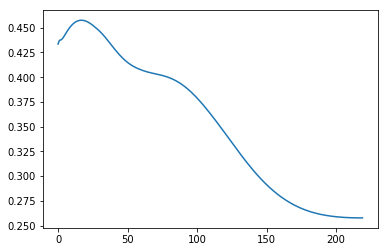

Seconds used for training: 72.0040
Match coefficient: 0.7333
[[25.  8.]
 [12. 30.]]


In [8]:
X = X_train_avg
target = y_train_avg
X_validate = X_validate_avg
y_validate = y_validate_avg
X_test = X_test_avg
y_test = y_test_avg

number_of_neurons_in_input = X.shape[1]
number_of_targets = target.shape[1]

net = mlp(number_of_neurons_in_input, number_of_neurons_in_hidden, number_of_targets, beta=beta)

t0 = time.time()
net.early_stopping(X, target, X_validate, y_validate, number_of_epochs)
t1 = time.time()
total_time = t1-t0
print("Seconds used for training: %0.4f" % total_time)

net.confusion(X_test, y_test)